# Practice Lab: Advice for Applying Machine Learning
In this lab, you will explore techniques to evaluate and improve your machine learning models.

# Outline
- [ 1 - Packages ](#1)
- [ 2 - Evaluating a Learning Algorithm (Polynomial Regression)](#2)
  - [ 2.1 Splitting your data set](#2.1)
  - [ 2.2 Error calculation for model evaluation, linear regression](#2.2)
    - [ Exercise 1](#ex01)
  - [ 2.3 Compare performance on training and test data](#2.3)
- [ 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> ](#3)
  - [ 3.1 Plot Train, Cross-Validation, Test](#3.1)
  - [ 3.2 Finding the optimal degree](#3.2)
  - [ 3.3 Tuning Regularization.](#3.3)
  - [ 3.4 Getting more data: Increasing Training Set Size (m)](#3.4)
- [ 4 - Evaluating a Learning Algorithm (Neural Network)](#4)
  - [ 4.1 Data Set](#4.1)
  - [ 4.2 Evaluating categorical model by calculating classification error](#4.2)
    - [ Exercise 2](#ex02)
- [ 5 - Model Complexity](#5)
  - [ Exercise 3](#ex03)
  - [ 5.1 Simple model](#5.1)
    - [ Exercise 4](#ex04)
- [ 6 - Regularization](#6)
  - [ Exercise 5](#ex05)
- [ 7 - Iterate to find optimal regularization value](#7)
  - [ 7.1 Test](#7.1)


<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [scikitlearn](https://scikit-learn.org/stable/) is a basic library for data mining
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.

In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import * 

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


<a name="2"></a>
## 2 - Evaluating a Learning Algorithm (Polynomial Regression)

<img align="Right" src="./images/C2_W3_TrainingVsNew.png"  style=" width:350px; padding: 10px 20px ; "> Let's say you have created a machine learning model and you find it *fits* your training data very well. You're done? Not quite. The goal of creating the model was to be able to predict values for <span style="color:blue">*new* </span> examples. 

How can you test your model's performance on new data before deploying it?   
The answer has two parts:
* Split your original data set into "Training" and "Test" sets. 
    * Use the training data to fit the parameters of the model
    * Use the test data to evaluate the model on *new* data
* Develop an error function to evaluate your model.

<a name="2.1"></a>
### 2.1 Splitting your data set
Lectures advised reserving 20-40% of your data set for testing. Let's use an `sklearn` function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to perform the split. Double-check the shapes after running the following cell.

In [2]:
# Generate some data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


#### 2.1.1 Plot Train, Test sets
You can see below the data points that will be part of training (in red) are intermixed with those that the model is not trained on (test). This particular data set is a quadratic function with noise added. The "ideal" curve is shown for reference.

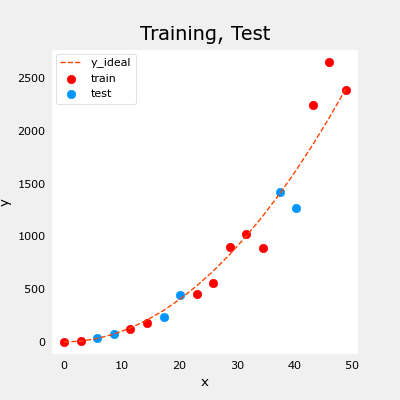

In [3]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="2.2"></a>
### 2.2 Error calculation for model evaluation, linear regression
When *evaluating* a linear regression model, you average the squared error difference of the predicted values and the target values.

$$ J_\text{test}(\mathbf{w},b) = 
            \frac{1}{2m_\text{test}}\sum_{i=0}^{m_\text{test}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{test}) - y^{(i)}_\text{test} )^2 
            \tag{1}
$$

<a name="ex01"></a>
### Exercise 1

Below, create a function to evaluate the error on a data set for a linear regression model.

In [4]:
# UNQ_C1
# GRADED CELL: eval_mse
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
    ### START CODE HERE ### 
        err+=(y[i]-yhat[i])**2
    ### END CODE HERE ### 
    err/= 2*m
    return(err)

In [5]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
eval_mse(y_hat, y_tmp)

# BEGIN UNIT TEST
test_eval_mse(eval_mse)   
# END UNIT TEST

 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>

    
```python
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
        err_i  = ( (yhat[i] - y[i])**2 ) 
        err   += err_i                                                                
    err = err / (2*m)                    
    return(err)
``` 

<a name="2.3"></a>
### 2.3 Compare performance on training and test data
Let's build a high degree polynomial model to minimize training error. This will use the linear_regression functions from `sklearn`. The code is in the imported utility file if you would like to see the details. The steps below are:
* create and fit the model. ('fit' is another name for training or running gradient descent).
* compute the error on the training data.
* compute the error on the test data.

In [6]:
# create a model in sklearn, train on training data
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# predict on test data, find error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

The computed error on the training set is substantially less than that of the test set. 

In [7]:
print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

training err 58.01, test err 171215.01


The following plot shows why this is. The model fits the training data very well. To do so, it has created a complex function. The test data was not part of the training and the model does a poor job of predicting on this data.  
This model would be described as 1) is overfitting, 2) has high variance 3) 'generalizes' poorly.

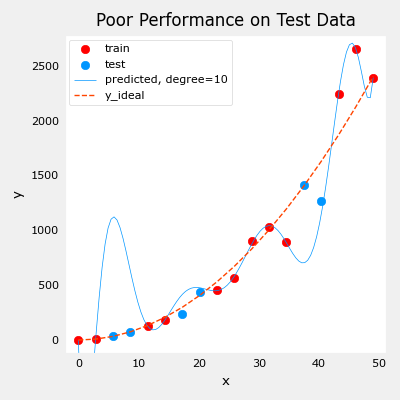

In [8]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

The test set error shows this model will not work well on new data. If you use the test error to guide improvements in the model, then the model will perform well on the test data... but the test data was meant to represent *new* data.
You need yet another set of data to test new data performance.

The proposal made during lecture is to separate data into three groups. The distribution of training, cross-validation and test sets shown in the below table is a typical distribution, but can be varied depending on the amount of data available.

| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| cross-validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network.|
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |


Let's generate three data sets below. We'll once again use `train_test_split` from `sklearn` but will call it twice to get three splits:

In [9]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


<a name="3"></a>
## 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> 
 Above, it was clear the degree of the polynomial model was too high. How can you choose a good value? It turns out, as shown in the diagram, the training and cross-validation performance can provide guidance. By trying a range of degree values, the training and cross-validation performance can be evaluated. As the degree becomes too large, the cross-validation performance will start to degrade relative to the training performance. Let's try this on our example.

<a name="3.1"></a>
### 3.1 Plot Train, Cross-Validation, Test
You can see below the datapoints that will be part of training (in red) are intermixed with those that the model is not trained on (test and cv).

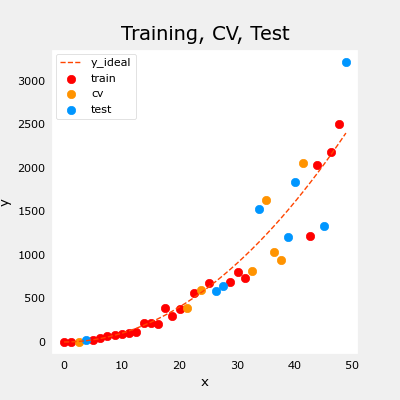

In [10]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="3.2"></a>
### 3.2 Finding the optimal degree
In previous labs, you found that you could create a model capable of fitting complex curves by utilizing a polynomial (See Course1, Week2 Feature Engineering and Polynomial Regression Lab).  Further, you demonstrated that by increasing the *degree* of the polynomial, you could *create* overfitting. (See Course 1, Week3, Over-Fitting Lab). Let's use that knowledge here to test our ability to tell the difference between over-fitting and under-fitting.

Let's train the model repeatedly, increasing the degree of the polynomial each iteration. Here, we're going to use the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) linear regression model for speed and simplicity.

In [11]:
max_degree = 9
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv)+1

<font size="4">Let's plot the result:</font>

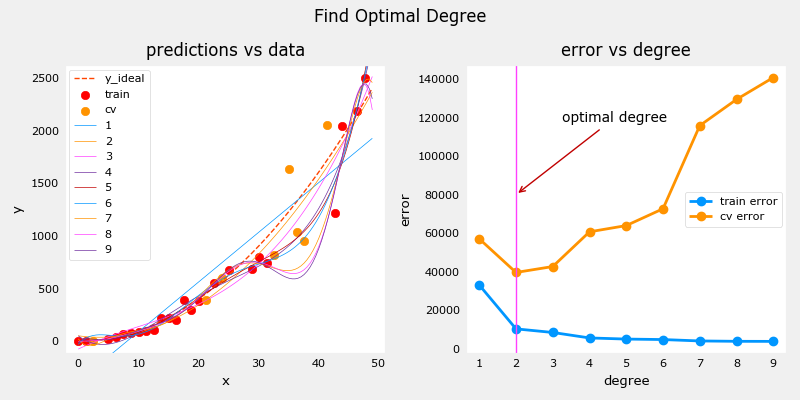

In [12]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

The plot above demonstrates that separating data into two groups, data the model is trained on and data the model has not been trained on, can be used to determine if the model is underfitting or overfitting. In our example, we created a variety of models varying from underfitting to overfitting by increasing the degree of the polynomial used. 
- On the left plot, the solid lines represent the predictions from these models. A polynomial model with degree 1 produces a straight line that intersects very few data points, while the maximum degree hews very closely to every data point. 
- on the right:
    - the error on the trained data (blue) decreases as the model complexity increases as expected
    - the error of the cross-validation data decreases initially as the model starts to conform to the data, but then increases as the model starts to over-fit on the training data (fails to *generalize*).     
    
It's worth noting that the curves in these examples as not as smooth as one might draw for a lecture. It's clear the specific data points assigned to each group can change your results significantly. The general trend is what is important.

<a name="3.3"></a>
### 3.3 Tuning Regularization.
In previous labs, you have utilized *regularization* to reduce overfitting. Similar to degree, one can use the same methodology to tune the regularization parameter lambda ($\lambda$).

Let's demonstrate this by starting with a high degree polynomial and varying the regularization parameter.

In [13]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

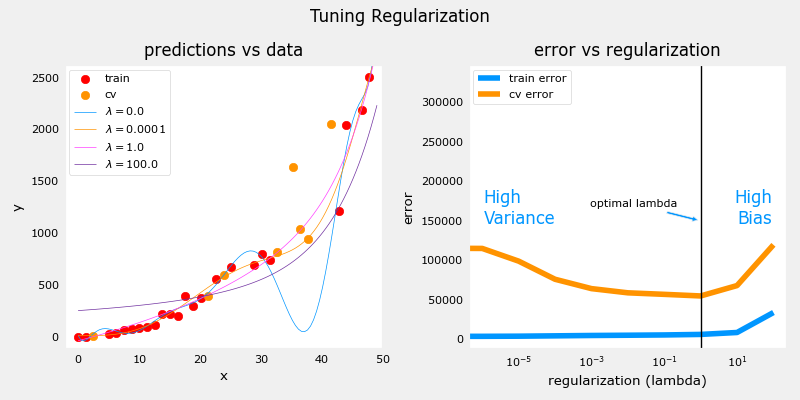

In [14]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Above, the plots show that as regularization increases, the model moves from a high variance (overfitting) model to a high bias (underfitting) model. The vertical line in the right plot shows the optimal value of lambda. In this example, the polynomial degree was set to 10. 

<a name="3.4"></a>
### 3.4 Getting more data: Increasing Training Set Size (m)
When a model is overfitting (high variance), collecting additional data can improve performance. Let's try that here.

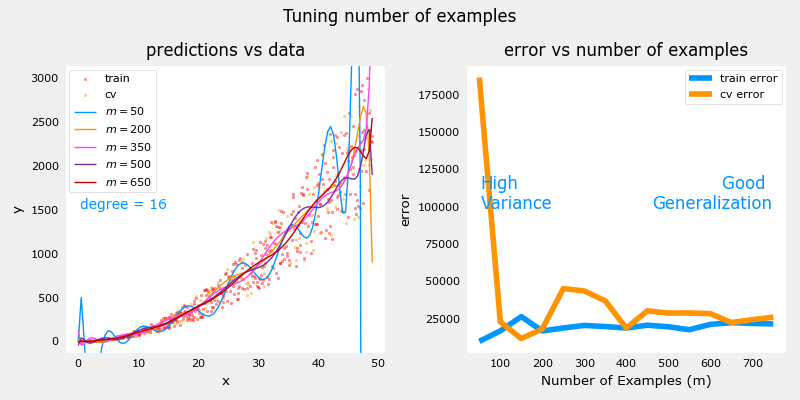

In [15]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

The above plots show that when a model has high variance and is overfitting, adding more examples improves performance. Note the curves on the left plot. The final curve with the highest value of $m$ is a smooth curve that is in the center of the data. On the right, as the number of examples increases, the performance of the training set and cross-validation set converge to similar values. Note that the curves are not as smooth as one might see in a lecture. That is to be expected. The trend remains clear: more data improves generalization. 

> Note that adding more examples when the model has high bias (underfitting) does not improve performance.


<a name="4"></a>
## 4 - Evaluating a Learning Algorithm (Neural Network)
Above, you tuned aspects of a polynomial regression model. Here, you will work with a neural network model. Let's start by creating a classification data set. 

<a name="4.1"></a>
### 4.1 Data Set
Run the cell below to generate a data set and split it into training, cross-validation (CV) and test sets. In this example, we're increasing the percentage of cross-validation data points for emphasis.  

In [16]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs() 

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


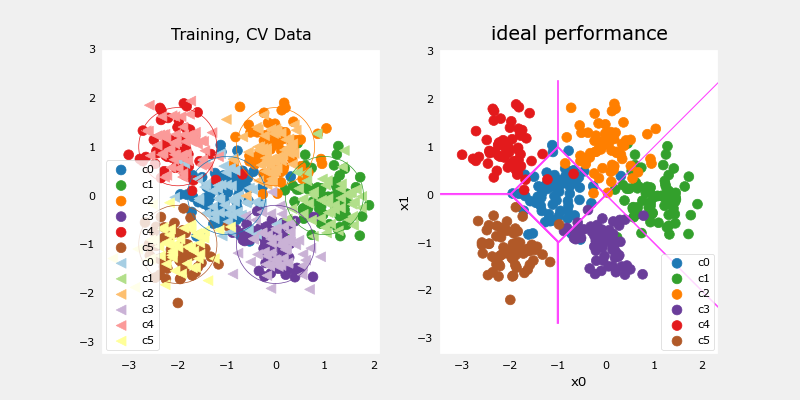

In [17]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

Above, you can see the data on the left. There are six clusters identified by color. Both training points (dots) and cross-validataion points (triangles) are shown. The interesting points are those that fall in ambiguous locations where either cluster might consider them members. What would you expect a neural network model to do? What would be an example of overfitting? underfitting?  
On the right is an example of an 'ideal' model, or a model one might create knowing the source of the data. The lines represent 'equal distance' boundaries where the distance between center points is equal. It's worth noting that this model would "misclassify" roughly 8% of the total data set.

<a name="4.2"></a>
### 4.2 Evaluating categorical model by calculating classification error
The evaluation function for categorical models used here is simply the fraction of incorrect predictions:  
$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1} 
\begin{cases}
    1, & \text{if $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{otherwise}
\end{cases}
$$

<a name="ex02"></a>
### Exercise 2

Below, complete the routine to calculate classification error. Note, in this lab, target values are the index of the category and are not [one-hot encoded](https://en.wikipedia.org/wiki/One-hot).

In [18]:
# UNQ_C2
# GRADED CELL: eval_cat_err
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
    ### START CODE HERE ### 
        if(yhat[i]!=y[i]):
            incorrect+=1
    ### END CODE HERE ### 
    cerr=incorrect/m
    return(cerr)

In [19]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )

# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST
# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST

categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250
 All tests passed.
 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
```python
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:    # @REPLACE
            incorrect += 1     # @REPLACE
    cerr = incorrect/m         # @REPLACE
    return(cerr)                                    
``` 

<a name="5"></a>
## 5 - Model Complexity
Below, you will build two models. A complex model and a simple model. You will evaluate the models to determine if they are likely to overfit or underfit.

###  5.1 Complex model

<a name="ex03"></a>
### Exercise 3
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation
* Dense layer with 40 units, relu activation
* Dense layer with 6 units and a linear activation (not softmax)  
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [22]:
# UNQ_C3
# GRADED CELL: model
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        ### START CODE HERE ### 
        tf.keras.layers.Dense(120, activation="relu"),
        tf.keras.layers.Dense(40, activation="relu"),
        tf.keras.layers.Dense(6, activation="linear")
        ### END CODE HERE ### 
    ], name="Complex"
)
model.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    ### END CODE HERE ### 
)

In [23]:
# BEGIN UNIT TEST
model.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.1106
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4281
Epoch 3/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3345
Epoch 4/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2896
Epoch 5/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2867
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2918
Epoch 7/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2497
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2298
Epoch 9/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2307
Epoch 10/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2071
Epoch 11/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2115
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2070
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 1ms/step - loss: 0.1141
Epoch 199/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1423
Epoch 200/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1381
Epoch 201/1000
13/13 [==============================] - 0s 917us/step - loss: 0.1105
Epoch 202/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1005
Epoch 203/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0846
Epoch 204/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.1125
Epoch 205/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1129
Epoch 206/1000
13/13 [==============================] - 0s 997us/step - loss: 0.1219
Epoch 207/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1161
Epoch 208/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1137
Epoch 209/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1178
Epoch 210/10

13/13 [==============================] - 0s 1ms/step - loss: 0.0663
Epoch 395/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0844
Epoch 396/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0704
Epoch 397/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0700
Epoch 398/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0591
Epoch 399/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.0586
Epoch 400/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0628
Epoch 401/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1717
Epoch 402/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1648
Epoch 403/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1616
Epoch 404/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1326
Epoch 405/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1367
Epoch 406/1000
1

13/13 [==============================] - 0s 2ms/step - loss: 0.0552
Epoch 493/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0602
Epoch 494/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0515
Epoch 495/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0586
Epoch 496/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0802
Epoch 497/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0489
Epoch 498/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0556
Epoch 499/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0523
Epoch 500/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0527
Epoch 501/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0496
Epoch 502/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0458
Epoch 503/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0405
Epoch 504/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0715
Epoch 689/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0687
Epoch 690/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0623
Epoch 691/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.0540
Epoch 692/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.0484
Epoch 693/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.0483
Epoch 694/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0388
Epoch 695/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0370
Epoch 696/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0343
Epoch 697/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0370
Epoch 698/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0348
Epoch 699/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0330
Epoch 700/

13/13 [==============================] - 0s 2ms/step - loss: 0.0358
Epoch 787/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0364
Epoch 788/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0381
Epoch 789/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0350
Epoch 790/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0738
Epoch 791/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0694
Epoch 792/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0483
Epoch 793/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0316
Epoch 794/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0263
Epoch 795/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0256
Epoch 796/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0269
Epoch 797/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0260
Epoch 798/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0298
Epoch 885/1000
13/13 [==============================] - 0s 917us/step - loss: 0.0195
Epoch 886/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0302
Epoch 887/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0231
Epoch 888/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0198
Epoch 889/1000
13/13 [==============================] - 0s 917us/step - loss: 0.0232
Epoch 890/1000
13/13 [==============================] - 0s 916us/step - loss: 0.0198
Epoch 891/1000
13/13 [==============================] - 0s 833us/step - loss: 0.0195
Epoch 892/1000
13/13 [==============================] - 0s 916us/step - loss: 0.0216
Epoch 893/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0196
Epoch 894/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0198
Epoch 895/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0187
Epoch 896

In [24]:
# BEGIN UNIT TEST
model.summary()

model_test(model, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "Complex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 120)               360       
_________________________________________________________________
dense_7 (Dense)              (None, 40)                4840      
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 246       
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Complex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(120, activation = 'relu', name = "L1"),      
        Dense(40, activation = 'relu', name = "L2"),         
        Dense(classes, activation = 'linear', name = "L3")  
    ], name="Complex"
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),          
    optimizer=tf.keras.optimizers.Adam(0.01),   
)

model.fit(
    X_train,y_train,
    epochs=1000
)                                  
``` 

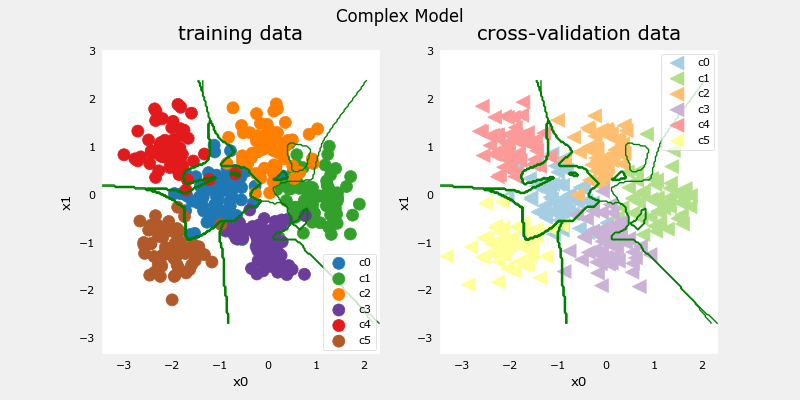

In [25]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

This model has worked very hard to capture outliers of each category. As a result, it has miscategorized some of the cross-validation data. Let's calculate the classification error.

In [26]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

categorization error, training, complex model: 0.010
categorization error, cv,       complex model: 0.116


<a name="5.1"></a>
### 5.1 Simple model
Now, let's try a simple model

<a name="ex04"></a>
### Exercise 4

Below, compose a two-layer model:
* Dense layer with 6 units, relu activation
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [28]:
# UNQ_C4
# GRADED CELL: model_s

tf.random.set_seed(1234)
model_s = Sequential(
    [
        ### START CODE HERE ### 
        tf.keras.layers.Dense(6, activation="relu"),
        tf.keras.layers.Dense(6, activation="linear")
        ### END CODE HERE ### 
    ], name = "Simple"
)
model_s.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    ### START CODE HERE ### 
)


In [29]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# BEGIN UNIT TEST
model_s.fit(
    X_train,y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 750us/step - loss: 1.7306
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.4468
Epoch 3/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.2902
Epoch 4/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.1367
Epoch 5/1000
13/13 [==============================] - 0s 997us/step - loss: 0.9710
Epoch 6/1000
13/13 [==============================] - 0s 916us/step - loss: 0.7947
Epoch 7/1000
13/13 [==============================] - 0s 999us/step - loss: 0.6499
Epoch 8/1000
13/13 [==============================] - 0s 916us/step - loss: 0.5378
Epoch 9/1000
13/13 [==============================] - 0s 919us/step - loss: 0.4652
Epoch 10/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4184
Epoch 11/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3860
Epoch 12/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.3641
Epoch 13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1859
Epoch 196/1000
13/13 [==============================] - 0s 917us/step - loss: 0.1856
Epoch 197/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1879
Epoch 198/1000
13/13 [==============================] - 0s 751us/step - loss: 0.1884
Epoch 199/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1894
Epoch 200/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.1860
Epoch 201/1000
13/13 [==============================] - 0s 917us/step - loss: 0.1869
Epoch 202/1000
13/13 [==============================] - 0s 832us/step - loss: 0.1837
Epoch 203/1000
13/13 [==============================] - 0s 669us/step - loss: 0.1861
Epoch 204/1000
13/13 [==============================] - 0s 916us/step - loss: 0.1869
Epoch 205/1000
13/13 [==============================] - 0s 916us/step - loss: 0.1846
Epoch 206/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.188

13/13 [==============================] - 0s 1000us/step - loss: 0.1809
Epoch 389/1000
13/13 [==============================] - 0s 916us/step - loss: 0.1807
Epoch 390/1000
13/13 [==============================] - 0s 916us/step - loss: 0.1792
Epoch 391/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1767
Epoch 392/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1767
Epoch 393/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1763
Epoch 394/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1768
Epoch 395/1000
13/13 [==============================] - 0s 917us/step - loss: 0.1789
Epoch 396/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1801
Epoch 397/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1805
Epoch 398/1000
13/13 [==============================] - 0s 917us/step - loss: 0.1783
Epoch 399/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1

13/13 [==============================] - 0s 1ms/step - loss: 0.1731
Epoch 582/1000
13/13 [==============================] - 0s 918us/step - loss: 0.1709
Epoch 583/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1727
Epoch 584/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1742
Epoch 585/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1721
Epoch 586/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1730
Epoch 587/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1728
Epoch 588/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1718
Epoch 589/1000
13/13 [==============================] - 0s 917us/step - loss: 0.1710
Epoch 590/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1787
Epoch 591/1000
13/13 [==============================] - 0s 917us/step - loss: 0.1789
Epoch 592/1000
13/13 [==============================] - 0s 836us/step - loss: 0.1745
Epoch 5

13/13 [==============================] - 0s 751us/step - loss: 0.1718
Epoch 679/1000
13/13 [==============================] - 0s 916us/step - loss: 0.1795
Epoch 680/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1709
Epoch 681/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.1703
Epoch 682/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1717
Epoch 683/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1758
Epoch 684/1000
13/13 [==============================] - 0s 837us/step - loss: 0.1699
Epoch 685/1000
13/13 [==============================] - 0s 916us/step - loss: 0.1753
Epoch 686/1000
13/13 [==============================] - 0s 917us/step - loss: 0.1728
Epoch 687/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1733
Epoch 688/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1706
Epoch 689/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1705


13/13 [==============================] - 0s 833us/step - loss: 0.1681
Epoch 871/1000
13/13 [==============================] - 0s 917us/step - loss: 0.1684
Epoch 872/1000
13/13 [==============================] - 0s 917us/step - loss: 0.1680
Epoch 873/1000
13/13 [==============================] - 0s 917us/step - loss: 0.1720
Epoch 874/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1705
Epoch 875/1000
13/13 [==============================] - 0s 666us/step - loss: 0.1686
Epoch 876/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1676
Epoch 877/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1750
Epoch 878/1000
13/13 [==============================] - 0s 917us/step - loss: 0.1728
Epoch 879/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1733
Epoch 880/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1690
Epoch 881/1000
13/13 [==============================] - 0s 833us/step - loss: 0.17

13/13 [==============================] - 0s 4ms/step - loss: 0.1697
Epoch 968/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1716
Epoch 969/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1688
Epoch 970/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1672
Epoch 971/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1664
Epoch 972/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1684
Epoch 973/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1660
Epoch 974/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1678
Epoch 975/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1675
Epoch 976/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1710
Epoch 977/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1722
Epoch 978/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1648
Epoch 979/1000
13/1

In [30]:
# BEGIN UNIT TEST
model_s.summary()

model_s_test(model_s, classes, X_train.shape[1])
# END UNIT TEST

Model: "Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 6)                 18        
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 42        
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 6)                 18        
_________________________________________________________________
L2 (Dense)                   (None, 6)                 42        
=================================================================
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(6, activation = 'relu', name="L1"),            # @REPLACE
        Dense(classes, activation = 'linear', name="L2")     # @REPLACE
    ], name = "Simple"
)
model_s.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),     # @REPLACE
    optimizer=tf.keras.optimizers.Adam(0.01),     # @REPLACE
)

model_s.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

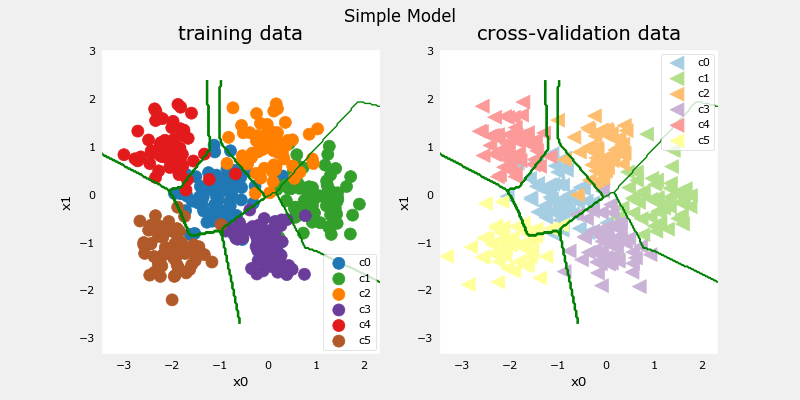

In [31]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

This simple models does pretty well. Let's calculate the classification error.

In [32]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

categorization error, training, simple model, 0.062, complex model: 0.010
categorization error, cv,       simple model, 0.087, complex model: 0.116


Our simple model has a little higher classification error on training data but does better on cross-validation data than the more complex model.

<a name="6"></a>
## 6 - Regularization
As in the case of polynomial regression, one can apply regularization to moderate the impact of a more complex model. Let's try this below.

<a name="ex05"></a>
### Exercise 5

Reconstruct your complex model, but this time include regularization.
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 40 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [33]:
# UNQ_C5
# GRADED CELL: model_r

tf.random.set_seed(1234)
model_r = Sequential(
    [
        ### START CODE HERE ### 
        tf.keras.layers.Dense(120, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(40, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(6, activation="linear")
        ### START CODE HERE ### 
    ], name= None
)
model_r.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    ### START CODE HERE ### 
)


In [34]:
# BEGIN UNIT TEST
model_r.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 920us/step - loss: 4.4464
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.7086
Epoch 3/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.3465
Epoch 4/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.0870
Epoch 5/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.0137
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9718
Epoch 7/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9481
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.8934
Epoch 9/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.8171
Epoch 10/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7715
Epoch 11/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7611
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7521
Epoch 13/1000
13/13 [==

13/13 [==============================] - 0s 915us/step - loss: 0.4191
Epoch 198/1000
13/13 [==============================] - 0s 833us/step - loss: 0.3963
Epoch 199/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.4080
Epoch 200/1000
13/13 [==============================] - 0s 916us/step - loss: 0.4032
Epoch 201/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.4268
Epoch 202/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.3954
Epoch 203/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3980
Epoch 204/1000
13/13 [==============================] - 0s 919us/step - loss: 0.4088
Epoch 205/1000
13/13 [==============================] - 0s 916us/step - loss: 0.4571
Epoch 206/1000
13/13 [==============================] - 0s 995us/step - loss: 0.4315
Epoch 207/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4097
Epoch 208/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.

13/13 [==============================] - 0s 1000us/step - loss: 0.4007
Epoch 295/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4066
Epoch 296/1000
13/13 [==============================] - 0s 917us/step - loss: 0.3768
Epoch 297/1000
13/13 [==============================] - 0s 833us/step - loss: 0.3841
Epoch 298/1000
13/13 [==============================] - 0s 916us/step - loss: 0.3884
Epoch 299/1000
13/13 [==============================] - 0s 916us/step - loss: 0.3926
Epoch 300/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.4250
Epoch 301/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3915
Epoch 302/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3894
Epoch 303/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3858
Epoch 304/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3804
Epoch 305/1000
13/13 [==============================] - 0s 917us/step - loss: 0.3810
Epo

13/13 [==============================] - 0s 1ms/step - loss: 0.3470
Epoch 488/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3539
Epoch 489/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3401
Epoch 490/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.3561
Epoch 491/1000
13/13 [==============================] - 0s 833us/step - loss: 0.3693
Epoch 492/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.3690
Epoch 493/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.3510
Epoch 494/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3548
Epoch 495/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3525
Epoch 496/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3736
Epoch 497/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4008
Epoch 498/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3497
Epoch 49

Epoch 682/1000
13/13 [==============================] - 0s 917us/step - loss: 0.3399
Epoch 683/1000
13/13 [==============================] - 0s 917us/step - loss: 0.3363
Epoch 684/1000
13/13 [==============================] - 0s 835us/step - loss: 0.3415
Epoch 685/1000
13/13 [==============================] - 0s 998us/step - loss: 0.3470
Epoch 686/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3487
Epoch 687/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3424
Epoch 688/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3321
Epoch 689/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.3976
Epoch 690/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3724
Epoch 691/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3471
Epoch 692/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.3554
Epoch 693/1000
13/13 [==============================] - 0s 1000us/step - 

13/13 [==============================] - 0s 1ms/step - loss: 0.3360
Epoch 877/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3316
Epoch 878/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3564
Epoch 879/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3425
Epoch 880/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.3270
Epoch 881/1000
13/13 [==============================] - ETA: 0s - loss: 0.249 - 0s 1000us/step - loss: 0.3594
Epoch 882/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3598
Epoch 883/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4354
Epoch 884/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3778
Epoch 885/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3704
Epoch 886/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3419
Epoch 887/1000
13/13 [==============================] - 0s 1ms/step - lo

In [37]:
# BEGIN UNIT TEST
model_r.summary()

model_r_test(model_r, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 120)               360       
_________________________________________________________________
dense_14 (Dense)             (None, 40)                4840      
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 246       
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
ddd
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "ComplexRegularized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"), 
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),  
        Dense(classes, activation = 'linear', name="L3")  
    ], name="ComplexRegularized"
)
model_r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.01),                             
)

model_r.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

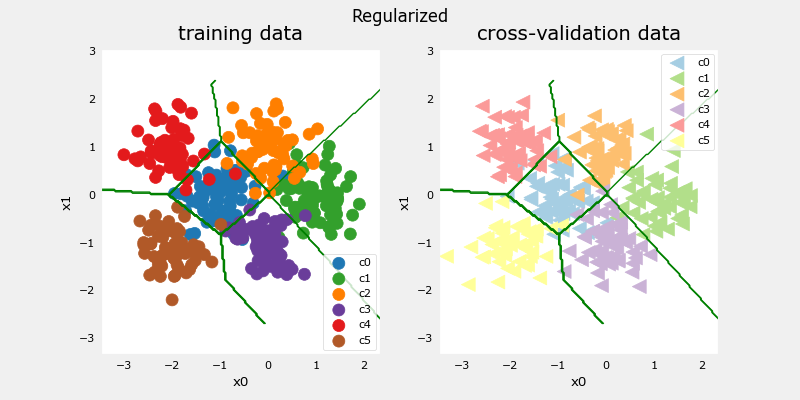

In [35]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

The results look very similar to the 'ideal' model. Let's check classification error.

In [38]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

categorization error, training, regularized: 0.072, simple model, 0.062, complex model: 0.010
categorization error, cv,       regularized: 0.066, simple model, 0.087, complex model: 0.116


The simple model is a bit better in the training set than the regularized model but it worse in the cross validation set.

<a name="7"></a>
## 7 - Iterate to find optimal regularization value
As you did in linear regression, you can try many regularization values. This code takes several minutes to run. If you have time, you can run it and check the results. If not, you have completed the graded parts of the assignment!

In [39]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")


Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.1106
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4281
Epoch 3/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3345
Epoch 4/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2896
Epoch 5/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2867
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2918
Epoch 7/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2497
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2298
Epoch 9/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2307
Epoch 10/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2071
Epoch 11/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2115
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2070
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 1ms/step - loss: 0.1141
Epoch 199/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1423
Epoch 200/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1381
Epoch 201/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1105
Epoch 202/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1005
Epoch 203/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0846
Epoch 204/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1125
Epoch 205/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1129
Epoch 206/1000
13/13 [==============================] - 0s 917us/step - loss: 0.1219
Epoch 207/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1161
Epoch 208/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.1137
Epoch 209/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1178
Epoch 210/10

13/13 [==============================] - 0s 1000us/step - loss: 0.0890
Epoch 297/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0800
Epoch 298/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.0803
Epoch 299/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.0765
Epoch 300/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.0733
Epoch 301/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0544
Epoch 302/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0718
Epoch 303/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0877
Epoch 304/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0687
Epoch 305/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0671
Epoch 306/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0575
Epoch 307/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0773
Epoch 3

13/13 [==============================] - 0s 1ms/step - loss: 0.0599
Epoch 492/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0552
Epoch 493/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0602
Epoch 494/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0515
Epoch 495/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0586
Epoch 496/1000
13/13 [==============================] - 0s 917us/step - loss: 0.0802
Epoch 497/1000
13/13 [==============================] - 0s 833us/step - loss: 0.0489
Epoch 498/1000
13/13 [==============================] - 0s 916us/step - loss: 0.0556
Epoch 499/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.0523
Epoch 500/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0527
Epoch 501/1000
13/13 [==============================] - 0s 999us/step - loss: 0.0496
Epoch 502/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0458
Epoch 50

13/13 [==============================] - 0s 1ms/step - loss: 0.0365
Epoch 590/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0392
Epoch 591/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.0435
Epoch 592/1000
13/13 [==============================] - 0s 918us/step - loss: 0.0477
Epoch 593/1000
13/13 [==============================] - 0s 917us/step - loss: 0.0515
Epoch 594/1000
13/13 [==============================] - 0s 916us/step - loss: 0.0426
Epoch 595/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0519
Epoch 596/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0481
Epoch 597/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0405
Epoch 598/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0603
Epoch 599/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0423
Epoch 600/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0356
Epoch 601/

13/13 [==============================] - 0s 1ms/step - loss: 0.0485
Epoch 784/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0437
Epoch 785/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0506
Epoch 786/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0358
Epoch 787/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.0364
Epoch 788/1000
13/13 [==============================] - 0s 919us/step - loss: 0.0381
Epoch 789/1000
13/13 [==============================] - 0s 917us/step - loss: 0.0350
Epoch 790/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.0738
Epoch 791/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0694
Epoch 792/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0483
Epoch 793/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0316
Epoch 794/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0263
Epoch 795

13/13 [==============================] - 0s 1000us/step - loss: 0.0480
Epoch 979/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.0509
Epoch 980/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.0383
Epoch 981/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0497
Epoch 982/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0372
Epoch 983/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.0378
Epoch 984/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0415
Epoch 985/1000
13/13 [==============================] - 0s 917us/step - loss: 0.0438
Epoch 986/1000
13/13 [==============================] - 0s 832us/step - loss: 0.0388
Epoch 987/1000
13/13 [==============================] - 0s 916us/step - loss: 0.0360
Epoch 988/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0500
Epoch 989/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0696
E

13/13 [==============================] - 0s 2ms/step - loss: 0.2109
Epoch 175/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1978
Epoch 176/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2058
Epoch 177/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2035
Epoch 178/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2134
Epoch 179/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2120
Epoch 180/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2032
Epoch 181/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2208
Epoch 182/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2110
Epoch 183/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2122
Epoch 184/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2098
Epoch 185/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2084
Epoch 186/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1775
Epoch 370/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.1890
Epoch 371/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.1755
Epoch 372/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1778
Epoch 373/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.1861
Epoch 374/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1799
Epoch 375/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1866
Epoch 376/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1800
Epoch 377/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1793
Epoch 378/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1850
Epoch 379/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1849
Epoch 380/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1833
Epoch 381/

13/13 [==============================] - 0s 2ms/step - loss: 0.1792
Epoch 468/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1744
Epoch 469/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1654
Epoch 470/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1720
Epoch 471/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1833
Epoch 472/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1737
Epoch 473/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1689
Epoch 474/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1731
Epoch 475/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1811
Epoch 476/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1756
Epoch 477/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1820
Epoch 478/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1972
Epoch 479/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1638
Epoch 662/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1606
Epoch 663/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1622
Epoch 664/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1666
Epoch 665/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1570
Epoch 666/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1608
Epoch 667/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1652
Epoch 668/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1617
Epoch 669/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1643
Epoch 670/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1612
Epoch 671/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1640
Epoch 672/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1693
Epoch 673/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1718
Epoch 858/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1733
Epoch 859/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1678
Epoch 860/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1573
Epoch 861/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1562
Epoch 862/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1626
Epoch 863/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1498
Epoch 864/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1548
Epoch 865/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1519
Epoch 866/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1544
Epoch 867/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1521
Epoch 868/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1591
Epoch 869/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3114
Epoch 55/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3593
Epoch 56/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3489
Epoch 57/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3277
Epoch 58/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3034
Epoch 59/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3298
Epoch 60/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3624
Epoch 61/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3687
Epoch 62/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3334
Epoch 63/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3205
Epoch 64/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3533
Epoch 65/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3558
Epoch 66/1000
13/13 [=========

13/13 [==============================] - 0s 1ms/step - loss: 0.2605
Epoch 252/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2468
Epoch 253/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2526
Epoch 254/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.2695
Epoch 255/1000
13/13 [==============================] - 0s 998us/step - loss: 0.2641
Epoch 256/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.2602
Epoch 257/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2919
Epoch 258/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2728
Epoch 259/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2527
Epoch 260/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2540
Epoch 261/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2679
Epoch 262/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2653
Epoch 263/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2939
Epoch 448/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2452
Epoch 449/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2321
Epoch 450/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2363
Epoch 451/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2472
Epoch 452/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2394
Epoch 453/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2387
Epoch 454/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2373
Epoch 455/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2383
Epoch 456/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2410
Epoch 457/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2328
Epoch 458/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2508
Epoch 459/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2365
Epoch 644/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2362
Epoch 645/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2460
Epoch 646/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2305
Epoch 647/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2367
Epoch 648/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2255
Epoch 649/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2348
Epoch 650/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2537
Epoch 651/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2377
Epoch 652/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2329
Epoch 653/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2212
Epoch 654/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2405
Epoch 655/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2286
Epoch 840/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2240
Epoch 841/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2376
Epoch 842/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2407
Epoch 843/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2402
Epoch 844/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2171
Epoch 845/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2288
Epoch 846/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2238
Epoch 847/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2356
Epoch 848/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2237
Epoch 849/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2212
Epoch 850/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2196
Epoch 851/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.5117
Epoch 37/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4785
Epoch 38/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4753
Epoch 39/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4653
Epoch 40/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4723
Epoch 41/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4891
Epoch 42/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4702
Epoch 43/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4732
Epoch 44/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4776
Epoch 45/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4861
Epoch 46/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4719
Epoch 47/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4354
Epoch 48/1000
13/13 [=========

13/13 [==============================] - 0s 1ms/step - loss: 0.3363
Epoch 234/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3360
Epoch 235/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3358
Epoch 236/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3414
Epoch 237/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3392
Epoch 238/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3709
Epoch 239/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3593
Epoch 240/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3367
Epoch 241/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3393
Epoch 242/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3365
Epoch 243/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3369
Epoch 244/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3468
Epoch 245/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3168
Epoch 430/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3069
Epoch 431/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3062
Epoch 432/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3096
Epoch 433/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3419
Epoch 434/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3591
Epoch 435/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3488
Epoch 436/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3521
Epoch 437/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3330
Epoch 438/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3322
Epoch 439/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3055
Epoch 440/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3063
Epoch 441/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2859
Epoch 626/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3012
Epoch 627/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3119
Epoch 628/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3220
Epoch 629/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3136
Epoch 630/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3089
Epoch 631/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3103
Epoch 632/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3292
Epoch 633/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3372
Epoch 634/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3033
Epoch 635/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3340
Epoch 636/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3206
Epoch 637/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3342
Epoch 822/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3019
Epoch 823/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2950
Epoch 824/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2926
Epoch 825/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3002
Epoch 826/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2912
Epoch 827/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2837
Epoch 828/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3008
Epoch 829/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3228
Epoch 830/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3516
Epoch 831/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3185
Epoch 832/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3020
Epoch 833/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.7118
Epoch 18/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7096
Epoch 19/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6862
Epoch 20/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6676
Epoch 21/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6589
Epoch 22/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6815
Epoch 23/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6695
Epoch 24/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6469
Epoch 25/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6573
Epoch 26/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7559
Epoch 27/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6332
Epoch 28/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6171
Epoch 29/1000
13/13 [=========

13/13 [==============================] - 0s 2ms/step - loss: 0.4062
Epoch 215/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3995
Epoch 216/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4097
Epoch 217/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3970
Epoch 218/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4177
Epoch 219/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4025
Epoch 220/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4018
Epoch 221/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3892
Epoch 222/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4103
Epoch 223/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4064
Epoch 224/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4411
Epoch 225/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4357
Epoch 226/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3846
Epoch 411/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3894
Epoch 412/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3757
Epoch 413/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3575
Epoch 414/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3544
Epoch 415/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3712
Epoch 416/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3780
Epoch 417/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3834
Epoch 418/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3596
Epoch 419/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3664
Epoch 420/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3501
Epoch 421/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3819
Epoch 422/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3698
Epoch 607/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3592
Epoch 608/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3457
Epoch 609/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3401
Epoch 610/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3579
Epoch 611/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3480
Epoch 612/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3584
Epoch 613/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3431
Epoch 614/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3386
Epoch 615/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3462
Epoch 616/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3406
Epoch 617/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3234
Epoch 618/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3211
Epoch 803/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3190
Epoch 804/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3198
Epoch 805/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3424
Epoch 806/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3446
Epoch 807/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3256
Epoch 808/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3519
Epoch 809/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3590
Epoch 810/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3361
Epoch 811/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3258
Epoch 812/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3147
Epoch 813/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3243
Epoch 814/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3193
Epoch 999/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3471
Epoch 1000/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3561
Finished lambda = 0.1
Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 7.3305
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 2.0539
Epoch 3/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.7673
Epoch 4/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.4216
Epoch 5/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.2743
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.2351
Epoch 7/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.1670
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.0987
Epoch 9/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.0284
Epoch 10/1000


13/13 [==============================] - 0s 1ms/step - loss: 0.4781
Epoch 196/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4782
Epoch 197/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4984
Epoch 198/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4815
Epoch 199/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4885
Epoch 200/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4851
Epoch 201/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5004
Epoch 202/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4760
Epoch 203/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4897
Epoch 204/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4938
Epoch 205/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5428
Epoch 206/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4986
Epoch 207/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4257
Epoch 392/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4339
Epoch 393/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4222
Epoch 394/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4364
Epoch 395/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4726
Epoch 396/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4845
Epoch 397/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4799
Epoch 398/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4498
Epoch 399/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4580
Epoch 400/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4503
Epoch 401/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4217
Epoch 402/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4205
Epoch 403/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4059
Epoch 588/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3806
Epoch 589/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3815
Epoch 590/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3795
Epoch 591/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3950
Epoch 592/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3908
Epoch 593/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3986
Epoch 594/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3971
Epoch 595/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4547
Epoch 596/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4217
Epoch 597/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3903
Epoch 598/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3899
Epoch 599/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3877
Epoch 784/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3774
Epoch 785/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3831
Epoch 786/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3857
Epoch 787/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3996
Epoch 788/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3730
Epoch 789/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3928
Epoch 790/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4130
Epoch 791/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4156
Epoch 792/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4274
Epoch 793/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4020
Epoch 794/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4147
Epoch 795/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3848
Epoch 980/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3959
Epoch 981/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3746
Epoch 982/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3669
Epoch 983/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3572
Epoch 984/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3822
Epoch 985/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3694
Epoch 986/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3760
Epoch 987/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3822
Epoch 988/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3587
Epoch 989/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3711
Epoch 990/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3606
Epoch 991/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.5925
Epoch 178/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5820
Epoch 179/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5750
Epoch 180/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5998
Epoch 181/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5778
Epoch 182/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5776
Epoch 183/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5683
Epoch 184/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5760
Epoch 185/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5767
Epoch 186/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5964
Epoch 187/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5766
Epoch 188/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5787
Epoch 189/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4981
Epoch 374/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5115
Epoch 375/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5029
Epoch 376/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5152
Epoch 377/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4865
Epoch 378/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4977
Epoch 379/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5074
Epoch 380/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4781
Epoch 381/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5396
Epoch 382/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5069
Epoch 383/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5307
Epoch 384/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4899
Epoch 385/1000
13/1

13/13 [==============================] - 0s 1000us/step - loss: 0.4586
Epoch 570/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.4650
Epoch 571/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.4613
Epoch 572/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4779
Epoch 573/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4621
Epoch 574/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.4679
Epoch 575/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4824
Epoch 576/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4483
Epoch 577/1000
13/13 [==============================] - 0s 917us/step - loss: 0.4471
Epoch 578/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5203
Epoch 579/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.4738
Epoch 580/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.4563

Epoch 667/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4525
Epoch 668/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4363
Epoch 669/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4520
Epoch 670/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4310
Epoch 671/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4660
Epoch 672/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4911
Epoch 673/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4413
Epoch 674/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4540
Epoch 675/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4527
Epoch 676/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4439
Epoch 677/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4560
Epoch 678/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4387
Epoc

13/13 [==============================] - 0s 1ms/step - loss: 0.4100
Epoch 864/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4665
Epoch 865/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4699
Epoch 866/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4448
Epoch 867/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4305
Epoch 868/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4167
Epoch 869/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4149
Epoch 870/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4555
Epoch 871/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4461
Epoch 872/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4055
Epoch 873/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4015
Epoch 874/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4146
Epoch 875/1000
13/1

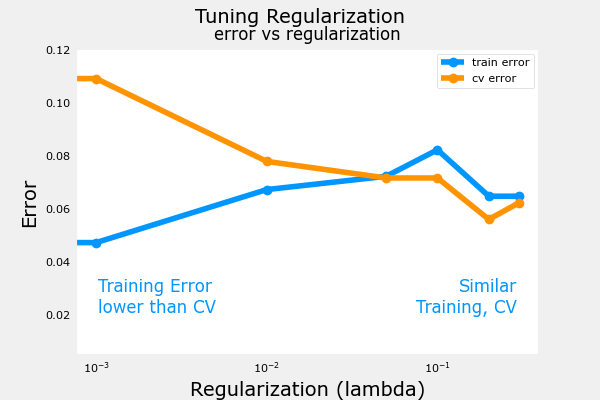

In [40]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

As regularization is increased, the performance of the model on the training and cross-validation data sets converge. For this data set and model, lambda > 0.01 seems to be a reasonable choice.

<a name="7.1"></a>
### 7.1 Test
Let's try our optimized models on the test set and compare them to 'ideal' performance. 

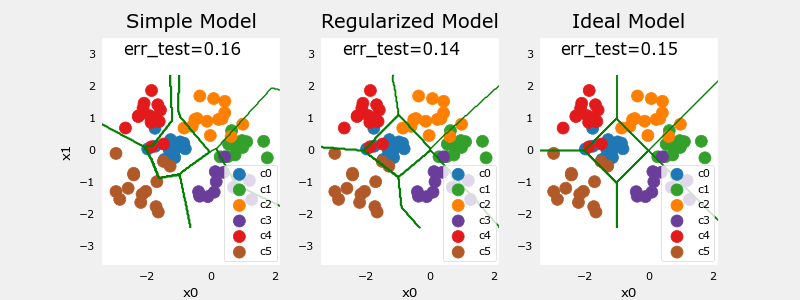

In [41]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)

Our test set is small and seems to have a number of outliers so classification error is high. However, the performance of our optimized models is comparable to ideal performance.

## Congratulations! 
You have become familiar with important tools to apply when evaluating your machine learning models. Namely:  
* splitting data into trained and untrained sets allows you to differentiate between underfitting and overfitting
* creating three data sets, Training, Cross-Validation and Test allows you to
    * train your parameters $W,B$ with the training set
    * tune model parameters such as complexity, regularization and number of examples with the cross-validation set
    * evaluate your 'real world' performance using the test set.
* comparing training vs cross-validation performance provides insight into a model's propensity towards overfitting (high variance) or underfitting (high bias)